<h2>Importing Libraries

In [1]:
import os


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as k_back
from tensorflow.keras.optimizers import Adam
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.8.0


<h2>Creating DenseNet121

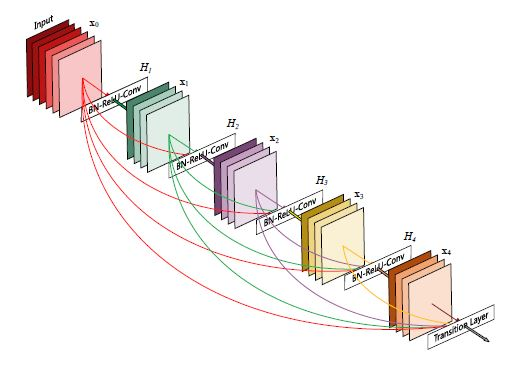
Figure 1: A dense block with 5 layers and growth rate 4<b><br>
from G. Huang, Z. Liu, van, and Weinberger, Kilian Q, “Densely Connected Convolutional Networks,” arXiv.org, 2016. arxiv.org/abs/1608.06993.

Function for sequence after input in convolutional block


In [2]:
def batch_relu_conv2(x,filters,kernel=1,strides=1):
        
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
    return x

Dense Block Function

In [3]:
def dense_block(x, repetition, filters = 32):
        
   for _ in range(repetition):
        y = batch_relu_conv2(x, 4*filters)
        y = batch_relu_conv2(y, filters, 3)
        x = concatenate([y,x])
   return x

Transition Layer Function

In [4]:
def transition_layer(x):
        
        x = batch_relu_conv2(x, k_back.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x

Collecting all pieces and to return model


In [5]:
def densenet(input_shape, n_classes, filter = 32):
    input = Input (input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    for repetition in [6,12,24,16]:
        
        d = dense_block(x, repetition, filter)
        x = transition_layer(d)
    x = GlobalAveragePooling2D()(d)
    #output = Dense(n_classes, activation = 'softmax')(x)
    output = Dense(n_classes, activation='sigmoid')(x)
    model = Model(input, output)
    return model

<h2> Checking dataset info

In [6]:
s1, s2 = 0, 0
for i in os.listdir("real_vs_fake/real-vs-fake/"):
    s1 += len(os.listdir("real_vs_fake/real-vs-fake/"+i+"/fake"))
    s2 += len(os.listdir("real_vs_fake/real-vs-fake/"+i+"/real"))
                
print(str(s1) + " fake images.")
print(str(s1) + " real images.")

70000 fake images.
70000 real images.


<h2>Preprocessing

In [7]:
image_sz = 100
batch_size = 100
data_generator = ImageDataGenerator(horizontal_flip=True)
path = "real_vs_fake/real-vs-fake/"

# Augment training data 
train_generator = data_generator.flow_from_directory(path+"train/", 
                                                    target_size=(image_sz,image_sz), 
                                                    color_mode='grayscale',
                                                   batch_size=batch_size,
                                                   class_mode='binary',
                                                   shuffle=True)

# Augment validation data 
val_generator = data_generator.flow_from_directory(path+"valid/", 
                                                    target_size=(image_sz,image_sz), 
                                                    color_mode='grayscale',
                                                   batch_size=batch_size,
                                                   class_mode='binary',
                                                   shuffle=False)


Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


<h2>Creating model using functions for Densenet

In [8]:
# model = input_shape = 224,224,1
# n_classes = 1
# model = densenet(input_shape,n_classes)


In [9]:
# model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
# model.summary()

In [10]:
# gpus = tf.config.list_physical_devices('GPU')
# print(tf.test.gpu_device_name())
# if gpus:
#   # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#   try:
#     tf.config.set_logical_device_configuration(
#         gpus[0],
#         [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Virtual devices must be set before GPUs have been initialized
#     print(e)

<!-- training_steps= train_generator.n//train_generator.batch_size
validation_steps = val_generator.n//val_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',
                            save_weights_only=True, mode='max',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss' , factor=0.1, patience=2, min_lr=1.0000e-09,model='auto')

callbacks = [PlotLossesKeras(), reduce_lr]

history = model.fit(
    train_generator,
    steps_per_epoch = (100000//100),
    validation_data = val_generator,
    validation_steps = (20000//100),
    epochs = 10,
) -->

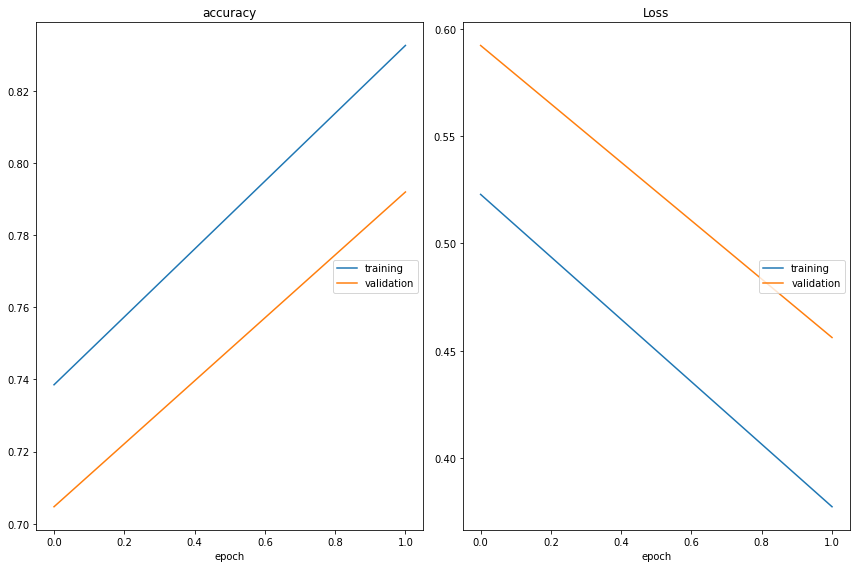

accuracy
	training         	 (min:    0.739, max:    0.833, cur:    0.833)
	validation       	 (min:    0.705, max:    0.792, cur:    0.792)
Loss
	training         	 (min:    0.377, max:    0.523, cur:    0.377)
	validation       	 (min:    0.456, max:    0.592, cur:    0.456)

Epoch 2: saving model to model_weights.h5
1000/1000 [==============================] - 635s 635ms/step - loss: 0.3773 - accuracy: 0.8325 - val_loss: 0.4561 - val_accuracy: 0.7919 - lr: 0.0010
Epoch 3/10
 204/1000 [=====>........................] - ETA: 7:55 - loss: 0.3155 - accuracy: 0.8652

In [ ]:
from tensorflow.keras.applications import DenseNet121
densenet = DenseNet121( weights=None, include_top=False, input_shape=(100,100,1) )
model = Sequential([ 
        densenet,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',
                            save_weights_only=True, mode='max',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss' , factor=0.1, patience=2, min_lr=1.0000e-09,model='auto')

callbacks = [PlotLossesKeras(), checkpoint, reduce_lr]

history = model.fit(
    train_generator,
    steps_per_epoch = (100000//100),
    validation_data = val_generator,
    validation_steps = (20000//100),
    epochs = 10,
        callbacks=callbacks
)

<h2>
    Testing

In [ ]:
# Augment test data 
test_generator = data_generator.flow_from_directory(path+"test/", 
                                                    target_size=(image_sz,image_sz), 
                                                    color_mode='grayscale',
                                                   batch_size=batch_size,
                                                   class_mode='binary',
                                                   shuffle=False)
y_pred = model.predict(test_generator)
y_test = test_generator.classes



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred.round()), annot = True,fmt="d",cmap = "Blues")
plt.show()

In [ ]:
print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))